In [1]:
import numpy as np
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar
from scrna.rmt._covariance import _compute_esd
import scrna._config

size = plt.rcParams['figure.figsize']
figsize=(3*size[0]/4, 0.75*size[1])

np.random.seed(0)
p = int(2*1600)
n = int(2*2000)

frac_1 = 60
frac_2 = 30

n = (n//frac_2)*frac_2
p = (p//frac_1)*frac_1

Xrand = np.random.normal(0, 1, size = (n,p))

u1 = np.zeros(p)
u1[2] = 0.2
u1[3] = 0.8
u1 /= np.sqrt((u1**2).sum())

u3 = np.random.uniform(0,1,n)
u3 /= np.sqrt((u3**2).sum())

val = 45
Q = val*u1[:,None]@u1[None,:]

In [11]:
p

3180

## Correlated $\rho_A \neq \delta(t-1)$

In [104]:
sigsp = np.concatenate((1*np.ones((frac_1 - 1)*(p//frac_1)), 12*np.ones(1*(p//frac_1))))
sigsn = np.concatenate((0.1*np.ones((frac_2 - 1)*(n//frac_2)), 8*np.ones(1*(n//frac_2))))

u2 = np.zeros(p)
u2[2] = 0.7
u2[3] = 0.3
u2 /= np.sqrt((u2**2).sum())

val2 = 2.0
P = val2*np.sqrt(n)*u3[:,None]@u2[None,:]

q = p/n
X = (np.diag(sigsn**(1/2)))@Xrand@sqrtm(np.diag(sigsp) + Q) + P

corr = (X.T@X)/(n - 1)
eigs, V = np.linalg.eigh(corr)

tr = np.sum(sigsn)/(n)
eigs_, V = np.linalg.eigh(tr*(np.diag(sigsp) + Q)+ P.T@P/(n))
eigs_ = np.sort(eigs_)[::-1]
outliers = eigs_[(np.abs(eigs_ - np.roll(eigs_, shift=-1)) > 0.2) 
                 & (np.abs(eigs_ - np.roll(eigs_, shift=+1)) > 0.2)]


eigs__, V = np.linalg.eigh((np.diag(sigsp) + Q))
eigs__ = np.sort(eigs__)[::-1]
outliers_ = eigs__[(np.abs(eigs__ - np.roll(eigs__, shift=-1)) > 0.2) 
                   & (np.abs(eigs__ - np.roll(eigs__, shift=+1)) > 0.2)]

grid = np.logspace(np.log10(0.001),np.log10(100),2000)
rho, m, mbar, g2 = _compute_esd(sigsp, sigsn, q = p/n, epsilon = 5e-3, grid = grid, wA = None, wB = None)

100%|██████████| 2000/2000 [00:06<00:00, 308.21it/s] 


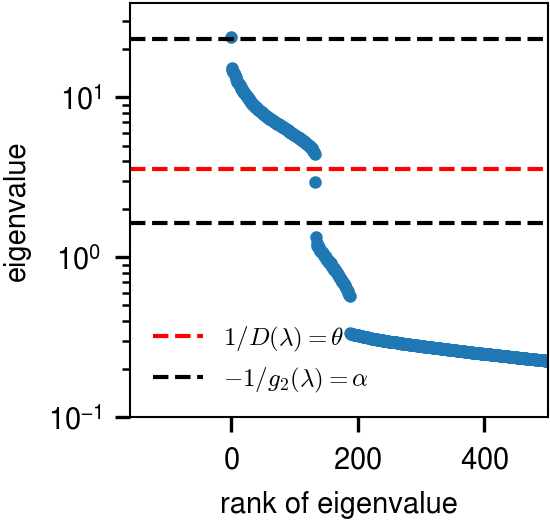

In [105]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(np.sort(eigs)[::-1], 'o', markersize=2)
ax.set_xlabel('rank of eigenvalue')
ax.set_ylabel('eigenvalue')
ax.set_yscale('log')
ax.set_xlim(xmax=500)
ax.set_ylim(ymin=0.1)

fD = interp1d(grid, np.abs(1/(mbar*m*grid) - val2**2))
res_D = minimize_scalar(fD, bounds=(0.1, 100))

fg2 = interp1d(grid, np.abs(-1/g2 - outliers_[0]))
res_1g2 = minimize_scalar(fg2, bounds=(0.1, 2))
res_2g2 = minimize_scalar(fg2, bounds=(2, 100))

plt.axhline(y = res_D.x, color='r', linestyle='--', label=r'$1/D(\lambda) = \theta$')
plt.axhline(y = res_1g2.x, color='k', linestyle='--', label=r'$-1/g_2(\lambda) = \alpha$')
plt.axhline(y = res_2g2.x, color='k', linestyle='--')

ax.legend(frameon=False, loc = 'lower left')
#fig.savefig('figures/unwhitened_correlated.pdf', dpi=300)

## Independent $\rho_A \neq \delta(t-1)$

In [106]:
u2 = np.random.uniform(0,1,p)
u2 /= np.sqrt((u2**2).sum())

val2 = 2.0
P = val2*np.sqrt(n)*u3[:,None]@u2[None,:]

q = p/n
X = (np.diag(sigsn**(1/2)))@Xrand@sqrtm(np.diag(sigsp) + Q) + P

corr = (X.T@X)/(n - 1)
eigs, V = np.linalg.eigh(corr)

tr = np.sum(sigsn)/(n)
eigs_, V = np.linalg.eigh(tr*(np.diag(sigsp) + Q)+ P.T@P/(n))
eigs_ = np.sort(eigs_)[::-1]
outliers = eigs_[(np.abs(eigs_ - np.roll(eigs_, shift=-1)) > 0.2) 
                 & (np.abs(eigs_ - np.roll(eigs_, shift=+1)) > 0.2)]

eigs__, V = np.linalg.eigh((np.diag(sigsp) + Q))
eigs__ = np.sort(eigs__)[::-1]
outliers_ = eigs__[(np.abs(eigs__ - np.roll(eigs__, shift=-1)) > 0.2) 
                   & (np.abs(eigs__ - np.roll(eigs__, shift=+1)) > 0.2)]

grid = np.logspace(np.log10(0.001),np.log10(100),2000)
rho, m, mbar, g2 = _compute_esd(sigsp, sigsn, q = p/n, epsilon = 5e-3, grid = grid, wA = None, wB = None)

100%|██████████| 2000/2000 [00:08<00:00, 233.13it/s] 


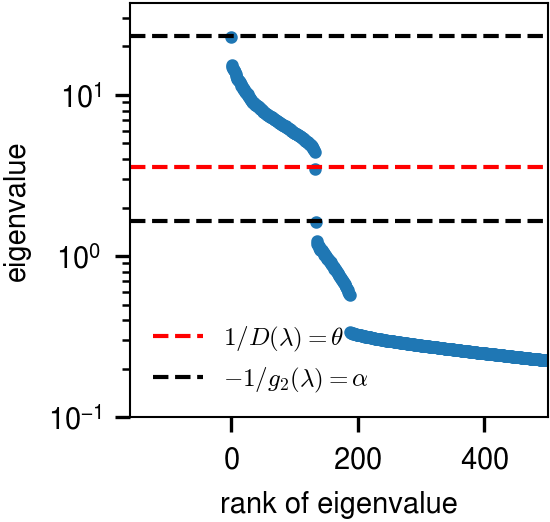

In [107]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(np.sort(eigs)[::-1], 'o', markersize=2)
ax.set_xlabel('rank of eigenvalue')
ax.set_ylabel('eigenvalue')
ax.set_yscale('log')
ax.set_xlim(xmax=500)
ax.set_ylim(ymin=0.1)

fD = interp1d(grid, np.abs(1/(mbar*m*grid) - val2**2))
res_D = minimize_scalar(fD, bounds=(0.1, 100))

fg2 = interp1d(grid, np.abs(-1/g2 - outliers_[0]))
res_1g2 = minimize_scalar(fg2, bounds=(0.1, 2))
res_2g2 = minimize_scalar(fg2, bounds=(2, 100))

plt.axhline(y = res_D.x, color='r', linestyle='--', label=r'$1/D(\lambda) = \theta$')
plt.axhline(y = res_1g2.x, color='k', linestyle='--', label=r'$-1/g_2(\lambda) = \alpha$')
plt.axhline(y = res_2g2.x, color='k', linestyle='--')

ax.legend(frameon=False, loc = 'lower left')
#fig.savefig('figures/unwhitened_independent.pdf', dpi=300)

## Independent $\rho_A = \delta(t-1)$

In [108]:
sigsp = np.concatenate((1*np.ones((frac_1 - 1)*(p//frac_1)), 12*np.ones(1*(p//frac_1))))
sigsn = np.concatenate((1*np.ones((frac_2 - 1)*(n//frac_2)), 1*np.ones(1*(n//frac_2))))

u2 = np.random.uniform(0,1,p)
u2 /= np.sqrt((u2**2).sum())

val = 45
Q = val*u1[:,None]@u1[None,:]

val2 = 2
P = val2*np.sqrt(n)*u3[:,None]@u2[None,:]

q = p/n
X = (np.diag(sigsn**(1/2)))@Xrand@sqrtm(np.diag(sigsp) + Q) + P

corr = (X.T@X)/(n - 1)
eigs, V = np.linalg.eigh(corr)

tr = np.sum(sigsn)/(n)
eigs_, V = np.linalg.eigh(tr*(np.diag(sigsp) + Q)+ P.T@P/(n))
eigs_ = np.sort(eigs_)[::-1]
outliers = eigs_[(np.abs(eigs_ - np.roll(eigs_, shift=-1)) > 0.4) & (np.abs(eigs_ - np.roll(eigs_, shift=+1)) > 0.4)]


eigs__, V = np.linalg.eigh((np.diag(sigsp) + Q))
eigs__ = np.sort(eigs__)[::-1]
outliers_ = eigs__[(~np.isin(eigs__, np.unique((sigsp))))]

grid = np.logspace(np.log10(0.001),np.log10(100),2000)
rho, m, mbar, g2 = _compute_esd(sigsp, sigsn, q = p/n, epsilon = 5e-3, grid = grid, wA = None, wB = None)

100%|██████████| 2000/2000 [00:25<00:00, 77.36it/s] 


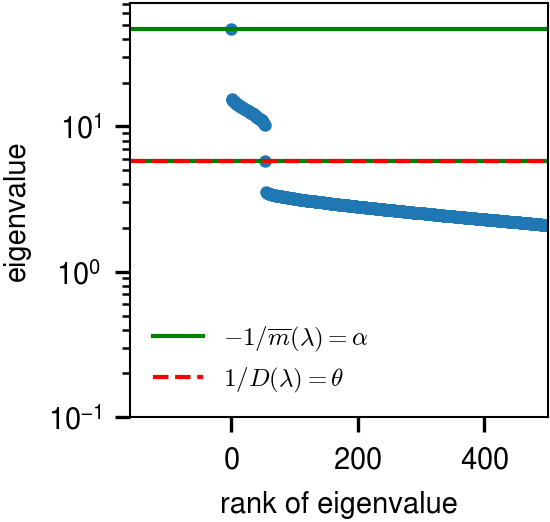

In [109]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(np.sort(eigs)[::-1], 'o', markersize=2)
ax.set_xlabel('rank of eigenvalue')
ax.set_ylabel('eigenvalue')
ax.set_yscale('log')
ax.set_xlim(xmax=500)
ax.set_ylim(ymin=0.1)

fD = interp1d(grid, np.abs(1/(mbar*m*grid) - val2**2))
res_D = minimize_scalar(fD, bounds=(0.1, 100))

for i in range(len(outliers)):
    fmbar = interp1d(grid, np.abs(-1/(mbar) - outliers[i]))
    res_mbar = minimize_scalar(fmbar, bounds=(0.1, 100))
    if i == 0:
        plt.axhline(y = res_mbar.x, color='g', linestyle='-', label=r'$-1/\overline{m}(\lambda) = \alpha$')
    else:
        plt.axhline(y = res_mbar.x, color='g', linestyle='-')
        
ax.axhline(y = res_D.x, color='r', linestyle='--', label=r'$1/D(\lambda) = \theta$')
ax.legend(frameon=False, loc = 'lower left')
#fig.savefig('figures/left_whitened_independent.pdf', dpi=300)

## Correlated $\rho_A = \delta(t-1)$

In [110]:
u2 = np.zeros(p)
u2[2] = 0.7
u2[3] = 0.3
u2 /= np.sqrt((u2**2).sum())

val = 45
Q = val*u1[:,None]@u1[None,:]

val2 = 2.0
P = val2*np.sqrt(n)*u3[:,None]@u2[None,:]

q = p/n
X = (np.diag(sigsn**(1/2)))@Xrand@sqrtm(np.diag(sigsp) + Q) + P

corr = (X.T@X)/(n - 1)
eigs, V = np.linalg.eigh(corr)

tr = np.sum(sigsn)/(n)
eigs_, V = np.linalg.eigh(tr*(np.diag(sigsp) + Q)+ P.T@P/(n))
eigs_ = np.sort(eigs_)[::-1]
outliers = eigs_[(np.abs(eigs_ - np.roll(eigs_, shift=-1)) > 0.4) & (np.abs(eigs_ - np.roll(eigs_, shift=+1)) > 0.4)]

eigs__, V = np.linalg.eigh((np.diag(sigsp) + Q))
eigs__ = np.sort(eigs__)[::-1]
outliers_ = eigs__[(np.abs(eigs__ - np.roll(eigs__, shift=-1)) > 0.4) & (np.abs(eigs__ - np.roll(eigs__, shift=+1)) > 0.4)]

grid = np.logspace(np.log10(0.001),np.log10(100),2000)
rho, m, mbar, g2 = _compute_esd(sigsp, sigsn, q = p/n, epsilon = 5e-3, grid = grid, wA = None, wB = None)

100%|██████████| 2000/2000 [00:25<00:00, 78.23it/s] 


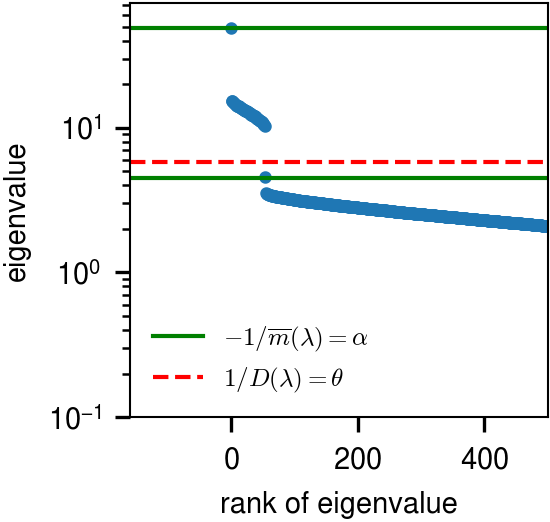

In [111]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(np.sort(eigs)[::-1], 'o', markersize=2)
ax.set_xlabel('rank of eigenvalue')
ax.set_ylabel('eigenvalue')
ax.set_yscale('log')
ax.set_xlim(xmax=500)
ax.set_ylim(ymin=0.1)

fD = interp1d(grid, np.abs(1/(mbar*m*grid) - val2**2))
res_D = minimize_scalar(fD, bounds=(0.1, 100))

for i in range(len(outliers)):
    fmbar = interp1d(grid, np.abs(-1/(mbar) - outliers[i]))
    res_mbar = minimize_scalar(fmbar, bounds=(0.1, 100))
    if i == 0:
        plt.axhline(y = res_mbar.x, color='g', linestyle='-', label=r'$-1/\overline{m}(\lambda) = \alpha$')
    else:
        plt.axhline(y = res_mbar.x, color='g', linestyle='-')
        
ax.axhline(y = res_D.x, color='r', linestyle='--', label=r'$1/D(\lambda) = \theta$')
ax.legend(frameon=False, loc = 'lower left')
#fig.savefig('figures/left_whitened_correlated.pdf', dpi=300)